# SFCA and RAAM script tests at Middle Layer Super Output Areas (MSOA) level using OSRM distance (30 miles threshold)

In [2]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats

# Data import

## Get LA——MSOA code data

In [2]:
LA_MSOA = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/LA_MSOA_code.csv')
LA_MSOA

LA_Code_2020 LA_name_2020  MSOA Code
0       E06000001   Hartlepool  E02002483
1       E06000001   Hartlepool  E02002484
2       E06000001   Hartlepool  E02002485
3       E06000001   Hartlepool  E02002487
4       E06000001   Hartlepool  E02002488
...           ...          ...        ...
6786    E09000033  Westminster  E02000979
6787    E09000033  Westminster  E02000980
6788    E09000033  Westminster  E02000981
6789    E09000033  Westminster  E02000982
6790    E09000033  Westminster  E02000983

[6791 rows x 3 columns]

## Get MSOA boundary data

In [3]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

<AxesSubplot:>

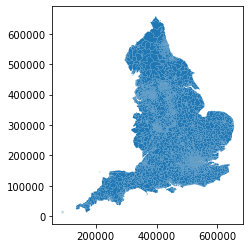

In [4]:
MSOA.plot()

## Get the population weighted centroid of MSOA (demand points)

In [5]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

<AxesSubplot:>

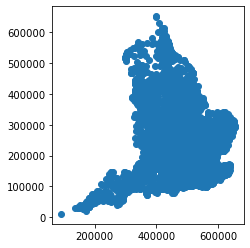

In [6]:
MSOA_points.plot()

### Calculate population over 60

In [7]:
MSOA_points['pop60+69'] = MSOA_points['pop60-69']

In [8]:
MSOA_points

objectid   msoa11cd  pop0-49  pop50-59  pop60-69  pop70-79  pop80-89  \
0            1  E02002536     5688      1416      1132       891       540   
1            2  E02002537     5578      1251       836       545       386   
2            3  E02002534     2547       824       863       967       407   
3            4  E02002535     4959      1636      1385       870       416   
4            5  E02002532     3783       970       810       655       342   
...        ...        ...      ...       ...       ...       ...       ...   
6786      6787  E02004669     3697      1171      1156       946       433   
6787      6788  E02006096     3893      1086       805       804       344   
6788      6789  E02003088     4007      1257      1230      1194       577   
6789      6790  E02006070     5161      1163       906       670       316   
6790      6791  E02006679     6429      1744      1408      1177       560   

      pop90+  total_pop                       geometry  pop60+69  
0        104       9771  POINT (445582.345 524175.434)      1132  
1         45       8641  POINT (446777.151 524256.841)       836  
2         85       5693  POINT (461356.929 515118.900)       863  
3         70       9336  POINT (446117.027 525455.836)      1385  
4         95       6655  POINT (461053.212 516175.379)       810  
...      ...        ...                            ...       ...  
6786      93       7496  POINT (393469.114 227500.260)      1156  
6787      69       7001  POINT (332829.367 109219.836)       805  
6788     179       8444  POINT (343276.340 158947.520)      1230  
6789      75       8291  POINT (331710.269 136880.200)       906  
6790      96      11414  POINT (390561.555 162786.953)      1408  

[6791 rows x 11 columns]

## read vaccination site point data (supply points)

In [9]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

In [10]:
site

index  supply_value                       geometry
0         0             1  POINT (504748.029 248914.642)
1         1             1  POINT (505059.230 222903.988)
2         2             1  POINT (532504.110 176066.629)
3         3             1  POINT (532504.110 176066.629)
4         4             1  POINT (504396.617 222557.941)
...     ...           ...                            ...
1595   1595             1   POINT (196928.058 72385.978)
1596   1596             1  POINT (524814.936 172019.963)
1597   1597             1  POINT (526813.753 181129.037)
1598   1598             1   POINT (408626.628 90816.439)
1599   1599             1  POINT (324002.981 121792.829)

[1600 rows x 3 columns]

# Read in the driving distance from the point of demand to the point of supply as cost (generated by driving_cost_calculation_OSRM.ipynb from data_raw folder)

In [11]:
distance_cost_df = pd.read_csv('distance_cost_final_OSRM.csv') 
distance_cost_df = distance_cost_df.rename(columns={"Distance in meter": "cost", "origin_id": "origin", "destination_id": "dest"})
distance_cost_df

cost     origin  dest
0         6712.7  E02002536   122
1        56619.8  E02002536   123
2        51152.7  E02002536   126
3        13881.2  E02002536   127
4        50625.1  E02002536   128
...          ...        ...   ...
1674418  48512.4  E02006679  1458
1674419  43150.5  E02006679  1460
1674420  26966.3  E02006679  1591
1674421  49329.1  E02006679  1592
1674422  60462.9  E02006679  1593

[1674423 rows x 3 columns]

# Calculate the MSOAs that have no vaccination service within 10 miles distance and plot the map

In [12]:
# Get demand MSOAs that have at least one vaccination site within 10 miles of distance
distance_cost_df_test = distance_cost_df.loc[distance_cost_df['cost']<16093.44]
distance_cost_df_test

a = pd.unique(distance_cost_df_test['origin'])

# Set 'MSOA_with_supply' field True if a place has at least one vaccination site within 10 miles of distance, otherwise False.
b = pd.DataFrame()
b['MSOA'] = a
b['MSOA_with_supply'] = True

MSOA_with_supply = pd.merge(left = MSOA,right = b, how='left', left_on='MSOA11CD', right_on='MSOA')
MSOA_with_supply=MSOA_with_supply.fillna(False)

### Count the number of MSOAs that are lack of vaccination service

In [13]:
m = MSOA_with_supply[MSOA_with_supply['MSOA_with_supply']==False]
print('There are ',m['MSOA11CD'].count(),'MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.')

There are  383 MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.


### Plot the regions that are lack of service

In [14]:
# Get the boundary of England
MSOA_with_supply['dissolve']=1
MSOA_outline = MSOA_with_supply.dissolve(by='dissolve')

In [3]:
#pip install cartopy

     |████████████████████████████████| 12.1 MB 5.0 MB/s eta 0:00:01   |▏                               | 81 kB 4.8 MB/s eta 0:00:03     |█████████████▉                  | 5.2 MB 5.0 MB/s eta 0:00:02     |█████████████████████████▋      | 9.7 MB 5.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 17.5 MB/s eta 0:00:01
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12888859 sha256=979aeeba424227c1372ac823c69683b6544a4ba792b4fc86295ed8919543cfe6
  Stored in directory: /home/jovyan/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37264 sha256=d0b7ba3982dd535c4365f004da0a3284ee0b6dd947eb441af08e80933f2748fa
  Stored in directory: /home/jovyan/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca

Text(0.5, 1.0, 'MSOAs Lack of Vaccination Service')

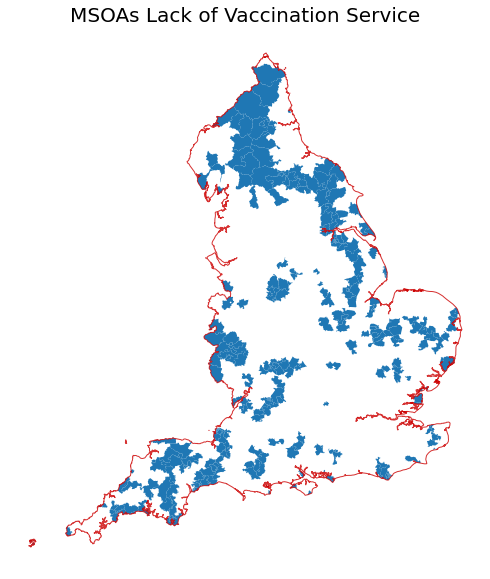

In [18]:
# Plot the map
f,ax = plt.subplots(figsize=(10,10))
m.plot(figsize = (10,10),ax=ax)
MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
ax.axis('off')
ax.set_title('MSOAs Lack of Vaccination Service', fontdict={'fontsize':'20', 'fontweight':'3'})

# Create a dataframe for the accessibility calculation using the Driving distance from the point of demand to the point of supply as cost

In [19]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='pop60+69',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value'],
           cost_df              = distance_cost_df,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           neighbor_cost_df     = distance_cost_df,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'cost')

### 2SFCA

In [20]:
# Using 2SFCA method, 16093.44 meters (10 miles) is used as service threshold radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca_10",max_cost = 16093.44)
fca.two_stage_fca(name = "2sfca_15",max_cost = 24140.16)
fca.two_stage_fca(name = "2sfca_20",max_cost = 32186.88)
fca.two_stage_fca(name = "2sfca_25",max_cost = 40233.60)
fca.two_stage_fca(name = "2sfca_30",max_cost = 48280.32)

2sfca_30_supply_value
msoa11cd                        
E02000001               0.001005
E02000002               0.001001
E02000003               0.000997
E02000004               0.000955
E02000005               0.000980
...                          ...
E02006930               0.000971
E02006931               0.000999
E02006932               0.000135
E02006933               0.000132
E02006934               0.000135

[6791 rows x 1 columns]

### E2SFCA

#### Set distance decay weight using gaussian function.

In [21]:
# Define a gaussian weight. Here, set the σ to be 5364.48 (meters), which is one third of the threshold, such that we'll be at the 3σ level at 16093.44 meters.
# According to the the empirical rule, also referred to as the three-sigma rule,
# for a normal distribution, almost all observed data will fall within three standard deviations.因此当距离接近threshold时，weight趋近于0
gaussian_10 = weights.gaussian(sigma =5364.48)
gaussian_15 = weights.gaussian(sigma =8064.72)
gaussian_20 = weights.gaussian(sigma =10728.96)
gaussian_25 = weights.gaussian(sigma =13411.20)
gaussian_30 = weights.gaussian(sigma =16093.44)

fca.enhanced_two_stage_fca(name = "E2sfca_10", weight_fn = gaussian_10)
fca.enhanced_two_stage_fca(name = "E2sfca_15", weight_fn = gaussian_15)
fca.enhanced_two_stage_fca(name = "E2sfca_20", weight_fn = gaussian_20)
fca.enhanced_two_stage_fca(name = "E2sfca_25", weight_fn = gaussian_25)
fca.enhanced_two_stage_fca(name = "E2sfca_30", weight_fn = gaussian_30)

E2sfca_30_supply_value
msoa11cd                         
E02000001                0.001665
E02000002                0.000698
E02000003                0.000726
E02000004                0.000612
E02000005                0.000752
...                           ...
E02006930                0.001331
E02006931                0.001405
E02006932                0.000176
E02006933                0.000158
E02006934                0.000167

[6791 rows x 1 columns]

### 3SFCA

In [22]:
fca.three_stage_fca(name = "3sfca_10", weight_fn = gaussian_10)

3sfca_10_supply_value
msoa11cd                        
E02000001               0.002644
E02000002               0.000402
E02000003               0.000446
E02000004               0.000308
E02000005               0.000449
...                          ...
E02006930               0.001224
E02006931               0.001311
E02006932               0.000101
E02006933               0.000074
E02006934               0.000102

[6791 rows x 1 columns]

In [23]:
fca.three_stage_fca(name = "3sfca_15", weight_fn = gaussian_15)

3sfca_15_supply_value
msoa11cd                        
E02000001               0.002012
E02000002               0.000574
E02000003               0.000608
E02000004               0.000486
E02000005               0.000626
...                          ...
E02006930               0.001305
E02006931               0.001372
E02006932               0.000104
E02006933               0.000089
E02006934               0.000100

[6791 rows x 1 columns]

In [24]:
fca.three_stage_fca(name = "3sfca_20", weight_fn = gaussian_20)

3sfca_20_supply_value
msoa11cd                        
E02000001               0.001673
E02000002               0.000687
E02000003               0.000702
E02000004               0.000583
E02000005               0.000706
...                          ...
E02006930               0.001275
E02006931               0.001331
E02006932               0.000117
E02006933               0.000105
E02006934               0.000108

[6791 rows x 1 columns]

In [25]:
fca.three_stage_fca(name = "3sfca_25", weight_fn = gaussian_25)

3sfca_25_supply_value
msoa11cd                        
E02000001               0.001484
E02000002               0.000734
E02000003               0.000747
E02000004               0.000633
E02000005               0.000752
...                          ...
E02006930               0.001234
E02006931               0.001274
E02006932               0.000125
E02006933               0.000116
E02006934               0.000116

[6791 rows x 1 columns]

In [26]:
fca.three_stage_fca(name = "3sfca_30", weight_fn = gaussian_30)

3sfca_30_supply_value
msoa11cd                        
E02000001               0.001366
E02000002               0.000757
E02000003               0.000772
E02000004               0.000672
E02000005               0.000782
...                          ...
E02006930               0.001187
E02006931               0.001217
E02006932               0.000133
E02006933               0.000125
E02006934               0.000126

[6791 rows x 1 columns]

## See the result

In [27]:
fca.access_df

pop60+69  2sfca_10_supply_value  2sfca_15_supply_value  \
msoa11cd                                                            
E02000001      1025               0.002110               0.001588   
E02000002       505               0.000397               0.000585   
E02000003       886               0.000392               0.000680   
E02000004       598               0.000276               0.000495   
E02000005       629               0.000386               0.000709   
...             ...                    ...                    ...   
E02006930       473               0.001573               0.001365   
E02006931       672               0.001757               0.001403   
E02006932       173               0.000184               0.000144   
E02006933       485               0.000173               0.000128   
E02006934       216               0.000115               0.000136   

           2sfca_20_supply_value  2sfca_25_supply_value  \
msoa11cd                                                  
E02000001               0.001263               0.001109   
E02000002               0.000917               0.000997   
E02000003               0.000955               0.001000   
E02000004               0.000882               0.000988   
E02000005               0.000996               0.000992   
...                          ...                    ...   
E02006930               0.001194               0.001064   
E02006931               0.001217               0.001075   
E02006932               0.000208               0.000160   
E02006933               0.000171               0.000160   
E02006934               0.000207               0.000160   

           2sfca_30_supply_value  E2sfca_10_supply_value  \
msoa11cd                                                   
E02000001               0.001005                0.003061   
E02000002               0.001001                0.000336   
E02000003               0.000997                0.000383   
E02000004               0.000955                0.000254   
E02000005               0.000980                0.000390   
...                          ...                     ...   
E02006930               0.000971                0.001373   
E02006931               0.000999                0.001540   
E02006932               0.000135                0.000139   
E02006933               0.000132                0.000093   
E02006934               0.000135                0.000113   

           E2sfca_15_supply_value  E2sfca_20_supply_value  \
msoa11cd                                                    
E02000001                0.002470                0.002103   
E02000002                0.000399                0.000496   
E02000003                0.000429                0.000527   
E02000004                0.000298                0.000393   
E02000005                0.000442                0.000550   
...                           ...                     ...   
E02006930                0.001472                0.001457   
E02006931                0.001628                0.001576   
E02006932                0.000159                0.000167   
E02006933                0.000124                0.000139   
E02006934                0.000129                0.000146   

           E2sfca_25_supply_value  E2sfca_30_supply_value  \
msoa11cd                                                    
E02000001                0.001849                0.001665   
E02000002                0.000605                0.000698   
E02000003                0.000636                0.000726   
E02000004                0.000508                0.000612   
E02000005                0.000663                0.000752   
...                           ...                     ...   
E02006930                0.001397                0.001331   
E02006931                0.001490                0.001405   
E02006932                0.000174                0.000176   
E02006933                0.000151                0.000158   
E02006934                0.000160     

In [28]:
fca.access_df.describe()

pop60+69  2sfca_10_supply_value  2sfca_15_supply_value  \
count  6791.000000            6408.000000            6711.000000   
mean    870.059638               0.000329               0.000308   
std     251.121854               0.000463               0.000393   
min      90.000000               0.000012               0.000012   
25%     696.000000               0.000114               0.000114   
50%     839.000000               0.000170               0.000161   
75%    1018.000000               0.000263               0.000229   
max    2082.000000               0.002241               0.001636   

       2sfca_20_supply_value  2sfca_25_supply_value  2sfca_30_supply_value  \
count            6776.000000            6786.000000            6788.000000   
mean                0.000302               0.000299               0.000297   
std                 0.000357               0.000336               0.000317   
min                 0.000011               0.000005               0.000015   
25%                 0.000117               0.000118               0.000119   
50%                 0.000160               0.000155               0.000155   
75%                 0.000217               0.000209               0.000209   
max                 0.001300               0.001120               0.001022   

       E2sfca_10_supply_value  E2sfca_15_supply_value  E2sfca_20_supply_value  \
count            6.790000e+03            6.790000e+03            6.790000e+03   
mean             3.135594e-04            3.117324e-04            3.094459e-04   
std              5.132016e-04            4.664580e-04            4.312549e-04   
min              6.463505e-25            6.379094e-14            4.084083e-10   
25%              8.106506e-05            1.003885e-04            1.111789e-04   
50%              1.626960e-04            1.628217e-04            1.629992e-04   
75%              2.834639e-04            2.570609e-04            2.430806e-04   
max              3.572851e-03            2.710417e-03            2.241470e-03   

       E2sfca_25_supply_value  E2sfca_30_supply_value  3sfca_10_supply_value  \
count            6.790000e+03            6.790000e+03           6.790000e+03   
mean             3.073042e-04            3.055004e-04           3.099127e-04   
std              4.049525e-04            3.849552e-04           4.654156e-04   
min              3.232218e-08            3.745771e-07           1.674476e-24   
25%              1.147844e-04            1.172642e-04           7.739582e-05   
50%              1.627306e-04            1.613171e-04           1.601164e-04   
75%              2.309653e-04            2.203265e-04           2.888902e-04   
max              1.935495e-03            1.722472e-03           2.954425e-03   

       3sfca_15_supply_value  3sfca_20_supply_value  3sfca_25_supply_value  \
count           6.790000e+03           6.790000e+03           6.790000e+03   
mean            3.063814e-04           3.040560e-04           3.022732e-04   
std             4.082133e-04           3.751712e-04           3.542361e-04   
min             4.538434e-13           2.835598e-09           1.204754e-07   
25%             9.998254e-05           1.100921e-04           1.157792e-04   
50%             1.631313e-04           1.610033e-04           1.604276e-04   
75%             2.660381e-04           2.583482e-04           2.567988e-04   
max             2.156257e-03           1.749759e-03           1.532678e-03   

       3sfca_30_supply_value  
count           6.790000e+03  
mean            3.007602e-04  
std             3.388606e-04  
min             8.139541e-07  
25%             1.185272e-04  
50%             1.591617e-04  
75%             2.584118e-04  
max             1.400600e-03

# Show the accessibility/vaccination rate result on map

In [29]:
MSOA_fca = pd.merge(left=MSOA, right=fca.access_df, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca = MSOA_fca.rename(columns={"2sfca_10_supply_value": "2sfca_10", "2sfca_15_supply_value": "2sfca_15", 
                                    "2sfca_20_supply_value": "2sfca_20", "2sfca_25_supply_value": "2sfca_25","2sfca_30_supply_value": "2sfca_30",
                                   "E2sfca_10_supply_value": "E2sfca_10", "E2sfca_15_supply_value": "E2sfca_15", 
                                    "E2sfca_20_supply_value": "E2sfca_20", "E2sfca_25_supply_value": "E2sfca_25","E2sfca_30_supply_value": "E2sfca_30",
                                   "3sfca_10_supply_value": "3sfca_10", "3sfca_15_supply_value": "3sfca_15", 
                                    "3sfca_20_supply_value": "3sfca_20", "3sfca_25_supply_value": "3sfca_25","3sfca_30_supply_value": "3sfca_30"})

## Use min-max normalization to normalize the accessibility score

In [30]:
MSOA_fca['2sfca_10_normalized'] = (MSOA_fca['2sfca_10']-MSOA_fca['2sfca_10'].min())/(MSOA_fca['2sfca_10'].max()-MSOA_fca['2sfca_10'].min())
MSOA_fca['2sfca_15_normalized'] = (MSOA_fca['2sfca_15']-MSOA_fca['2sfca_15'].min())/(MSOA_fca['2sfca_15'].max()-MSOA_fca['2sfca_15'].min())
MSOA_fca['2sfca_20_normalized'] = (MSOA_fca['2sfca_20']-MSOA_fca['2sfca_20'].min())/(MSOA_fca['2sfca_20'].max()-MSOA_fca['2sfca_20'].min())
MSOA_fca['2sfca_25_normalized'] = (MSOA_fca['2sfca_25']-MSOA_fca['2sfca_25'].min())/(MSOA_fca['2sfca_25'].max()-MSOA_fca['2sfca_25'].min())
MSOA_fca['2sfca_30_normalized'] = (MSOA_fca['2sfca_30']-MSOA_fca['2sfca_30'].min())/(MSOA_fca['2sfca_30'].max()-MSOA_fca['2sfca_30'].min())


MSOA_fca['E2sfca_10_normalized'] = (MSOA_fca['E2sfca_10']-MSOA_fca['E2sfca_10'].min())/(MSOA_fca['E2sfca_10'].max()-MSOA_fca['E2sfca_10'].min())
MSOA_fca['E2sfca_15_normalized'] = (MSOA_fca['E2sfca_15']-MSOA_fca['E2sfca_15'].min())/(MSOA_fca['E2sfca_15'].max()-MSOA_fca['E2sfca_15'].min())
MSOA_fca['E2sfca_20_normalized'] = (MSOA_fca['E2sfca_20']-MSOA_fca['E2sfca_20'].min())/(MSOA_fca['E2sfca_20'].max()-MSOA_fca['E2sfca_20'].min())
MSOA_fca['E2sfca_25_normalized'] = (MSOA_fca['E2sfca_25']-MSOA_fca['E2sfca_25'].min())/(MSOA_fca['E2sfca_25'].max()-MSOA_fca['E2sfca_25'].min())
MSOA_fca['E2sfca_30_normalized'] = (MSOA_fca['E2sfca_30']-MSOA_fca['E2sfca_30'].min())/(MSOA_fca['E2sfca_30'].max()-MSOA_fca['E2sfca_30'].min())

MSOA_fca['3sfca_10_normalized'] = (MSOA_fca['3sfca_10']-MSOA_fca['3sfca_10'].min())/(MSOA_fca['3sfca_10'].max()-MSOA_fca['2sfca_10'].min())
MSOA_fca['3sfca_15_normalized'] = (MSOA_fca['3sfca_15']-MSOA_fca['3sfca_15'].min())/(MSOA_fca['3sfca_15'].max()-MSOA_fca['2sfca_15'].min())
MSOA_fca['3sfca_20_normalized'] = (MSOA_fca['3sfca_20']-MSOA_fca['3sfca_20'].min())/(MSOA_fca['3sfca_20'].max()-MSOA_fca['2sfca_20'].min())
MSOA_fca['3sfca_25_normalized'] = (MSOA_fca['3sfca_25']-MSOA_fca['3sfca_25'].min())/(MSOA_fca['3sfca_25'].max()-MSOA_fca['2sfca_25'].min())
MSOA_fca['3sfca_30_normalized'] = (MSOA_fca['3sfca_30']-MSOA_fca['3sfca_30'].min())/(MSOA_fca['3sfca_30'].max()-MSOA_fca['2sfca_30'].min())


#MSOA_fca['raam_normalized'] = (MSOA_fca['raam']-MSOA_fca['raam'].min())/(MSOA_fca['raam'].max()-MSOA_fca['raam'].min())
#MSOA_fca['raam_inverse_normalize'] = 1-MSOA_fca['raam_normalized']

In [31]:
# Read the vaccination population data
url = 'https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/vaccination_number_2020_12_8_2021_3_7.csv'
vaccination_pop = pd.read_csv(url)
vaccination_pop['60-69'] = vaccination_pop['over60_64'] + vaccination_pop['over65_69']

# merge the population data
MSOA_fca = pd.merge(left = MSOA_fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA_code')

# merge the LA information
MSOA_fca = pd.merge(left = MSOA_fca, right=LA_MSOA, how='left', left_on='MSOA11CD', right_on='MSOA Code')

# Calculate vaccination rate
MSOA_fca['vaccination_percentage_for60+69'] = MSOA_fca['60-69']/MSOA_fca['pop60+69']

# Set vaccination rate greater than 1 to 1
MSOA_fca['vaccination_rate_60+69']= np.where(MSOA_fca['vaccination_percentage_for60+69']>1, 1, MSOA_fca['vaccination_percentage_for60+69'])

MSOA_code  under60  over60_64  over65_69  over70_74  over75_79  over80
0     E02002796      741        323        393        426        352     458
1     E02002797      796        410        411        521        468     872
2     E02002798     1422        687        530        511        308     369
3     E02002799      937        262        196        205        158     234
4     E02002800      782        342        331        375        293     515
...         ...      ...        ...        ...        ...        ...     ...
6786  E02002478      754        280        285        275        198     207
6787  E02002479     1016        387        518        469        432     438
6788  E02002480      563        291        374        304        270     314
6789  E02002481      797        350        348        308        227     360
6790  E02002482      788        265        326        295        228     283

[6791 rows x 7 columns]

In [34]:
# Subset the columns to only needed ones
MSOA_fca = MSOA_fca[['LA_Code_2020','LA_name_2020','MSOA11CD','MSOA11NM','pop60+69','60-69',
                     'vaccination_rate_60+69',
                     '2sfca_10_normalized','2sfca_15_normalized','2sfca_20_normalized','2sfca_25_normalized','2sfca_30_normalized',
                     'E2sfca_10_normalized','E2sfca_15_normalized','E2sfca_20_normalized','E2sfca_25_normalized','E2sfca_30_normalized',
                     '3sfca_10_normalized','3sfca_15_normalized','3sfca_20_normalized','3sfca_25_normalized','3sfca_30_normalized',
                     'geometry']]

<AxesSubplot:>

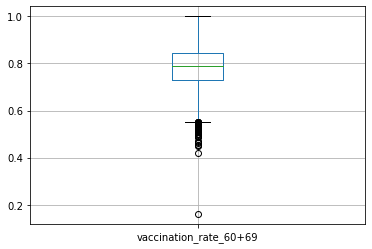

In [35]:
MSOA_fca.boxplot('vaccination_rate_60+69')

In [140]:
# Export result data
MSOA_fca.to_csv('fca_result_include_London.csv',index=False)
MSOA_fca.to_file("fca_result_include_London.gpkg", driver="GPKG")

In [141]:
MSOA_fca.shape

(6791, 23)

# Read data for plotting (generated above)

In [5]:
MSOA_fca = gpd.read_file('fca_result_include_London.gpkg')
MSOA_fca = MSOA_fca.to_crs('epsg:27700')

## Map plot code

In [6]:
# function for scale bar
import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.

    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        return geodesic.inverse(a_phys, b_phys).base[0, 0]

    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.

    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.

    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)

In [9]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

In [37]:
# for Accessibility (continuous)
def access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

In [38]:
# for Accessibility (natural break)
def access_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [39]:
# for Vaccination Rate (continuous)
def pop_rate(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

In [40]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [45]:
# for London accessibility map only
def access_break_London(column):
    f,ax = plt.subplots(figsize=(10,10))
    London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('London Vaccination Accessibility in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessibility")

    q = mc.NaturalBreaks(London[column], k=7)
    legendgram(f, ax, 
                London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

## Accessibility (When the service radius is 10/15/20/25/30 miles driving distance)

In [7]:
# plot function
def access_break_1(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    #ax.set_title('England Vaccination Accessibility in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Accessibility")
    ax.get_legend().get_title().set_fontsize('15')
    
    # north arrow
    ax.text(x=110000, y=590000, s='N', fontsize=30)
    ax.arrow(120000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    # scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)
    
    ax2 = fig.add_axes([0.1, 0.35, 0.3, 0.3])
    MSOA_fca.plot(column=column,edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([502300,562800])
    ax2.set_ylim([154800,201800])
    ax2.set_title('London', fontdict={'fontsize':'20', 'fontweight':'3'})
    London_boundary.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(fig, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

### 2SFCA

#### 10 miles

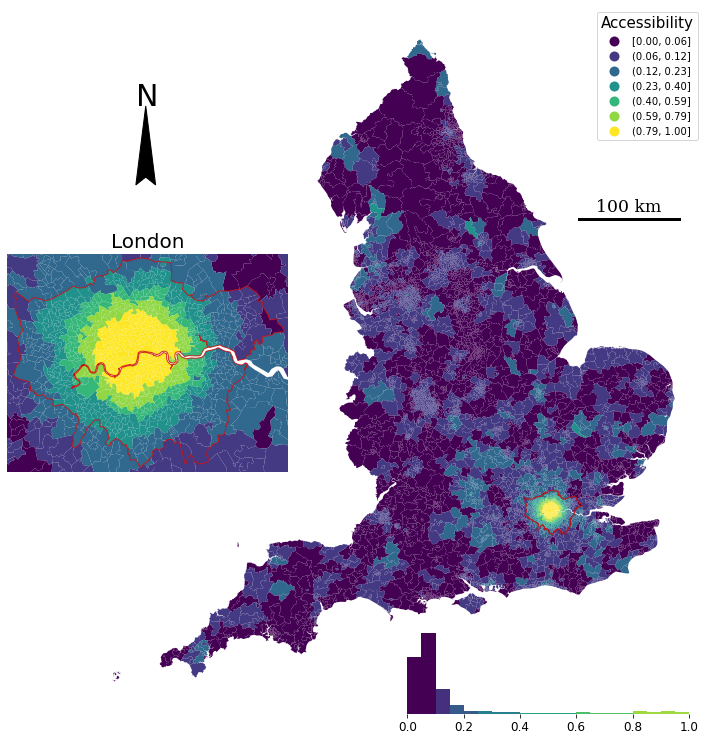

In [10]:
access_break_1('2sfca_10_normalized')
#plt.savefig('figure/2sfca_10_include', dpi=600)

#### 15miles

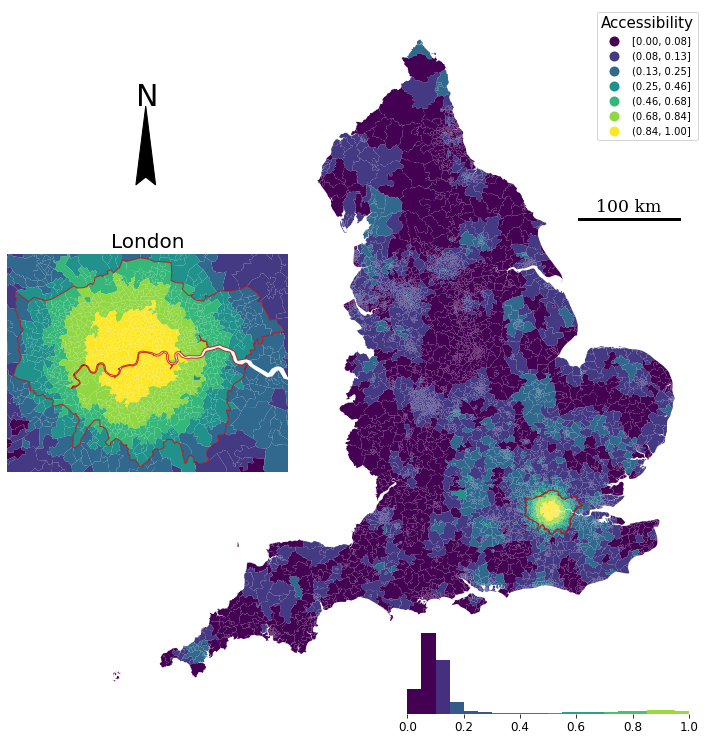

In [150]:
access_break_1('2sfca_15_normalized')
plt.savefig('figure/2sfca_15_include', dpi=600)

#### 20miles

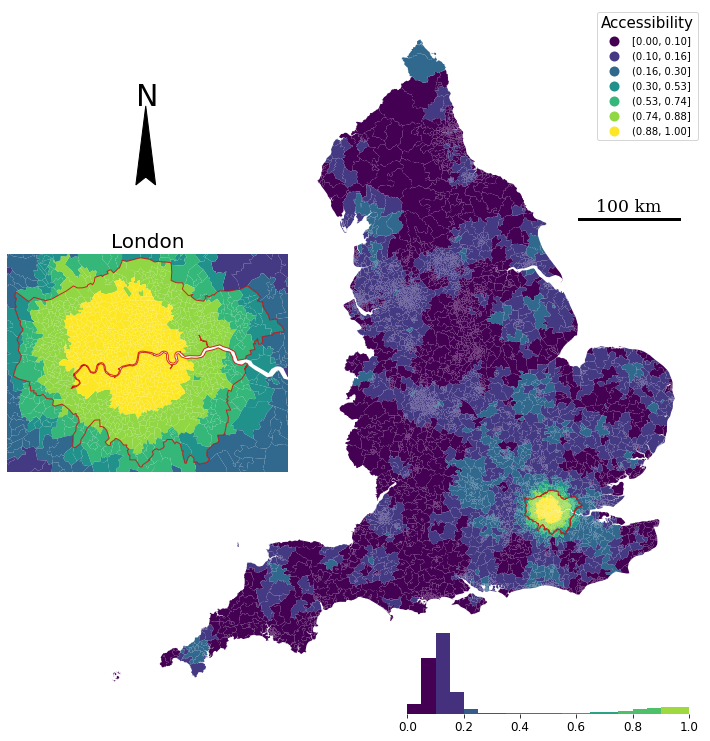

In [151]:
access_break_1('2sfca_20_normalized')
plt.savefig('figure/2sfca_20_include', dpi=600)

#### 25 miles

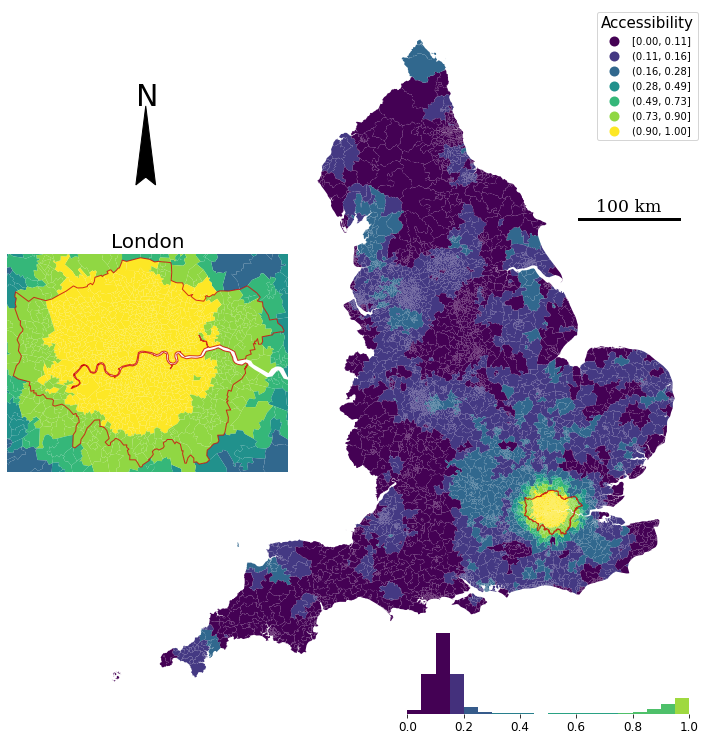

In [152]:
access_break_1('2sfca_25_normalized')
plt.savefig('figure/2sfca_25_include', dpi=600)

#### 30 miles

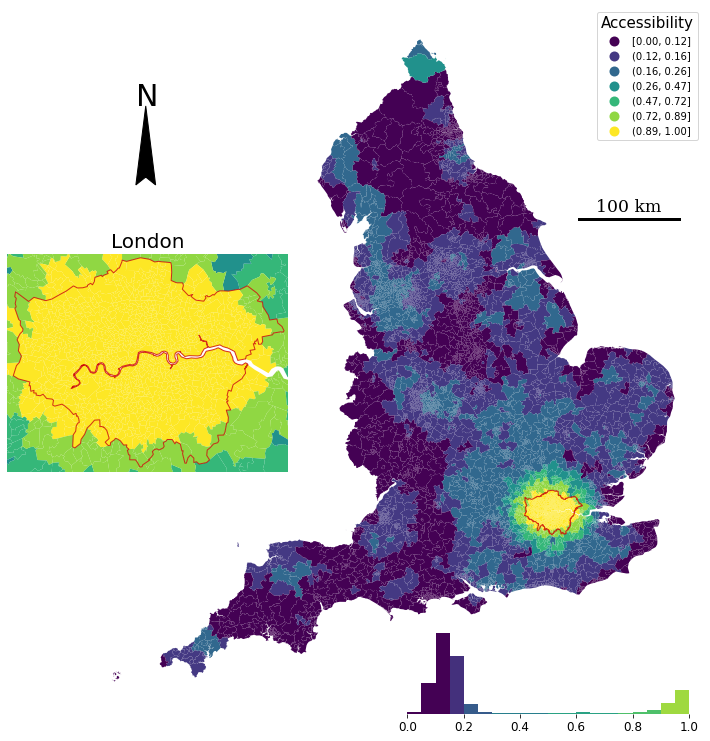

In [153]:
access_break_1('2sfca_30_normalized')
plt.savefig('figure/2sfca_30_include', dpi=600)

### E2SFCA

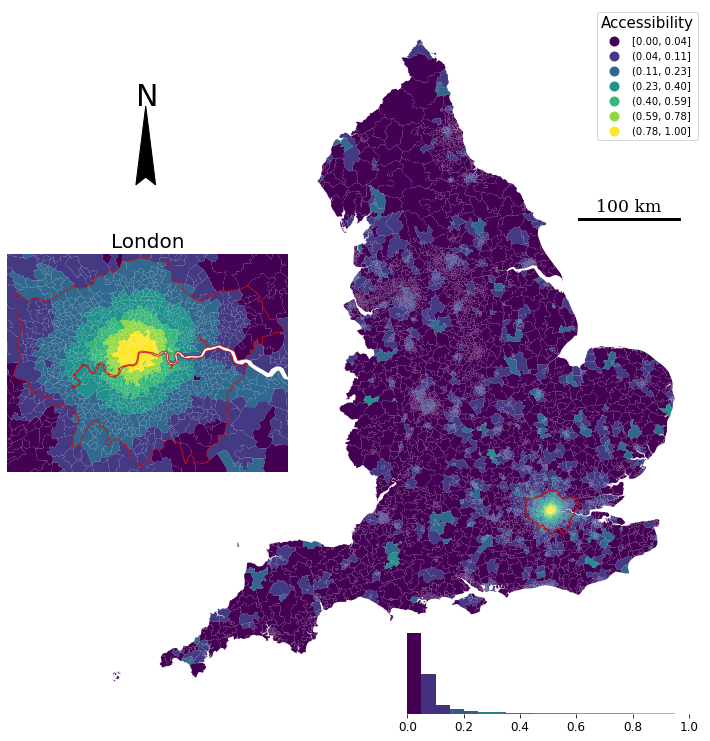

In [154]:
# 10 miles
access_break_1('E2sfca_10_normalized')
plt.savefig('figure/E2sfca_10_include', dpi=600)

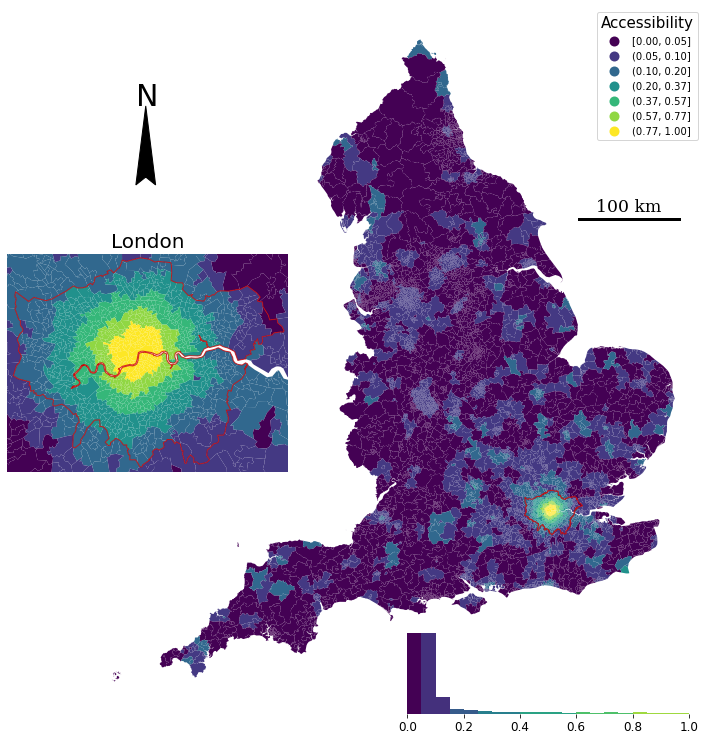

In [155]:
# 15 miles
access_break_1('E2sfca_15_normalized')
plt.savefig('figure/E2sfca_15_include', dpi=600)

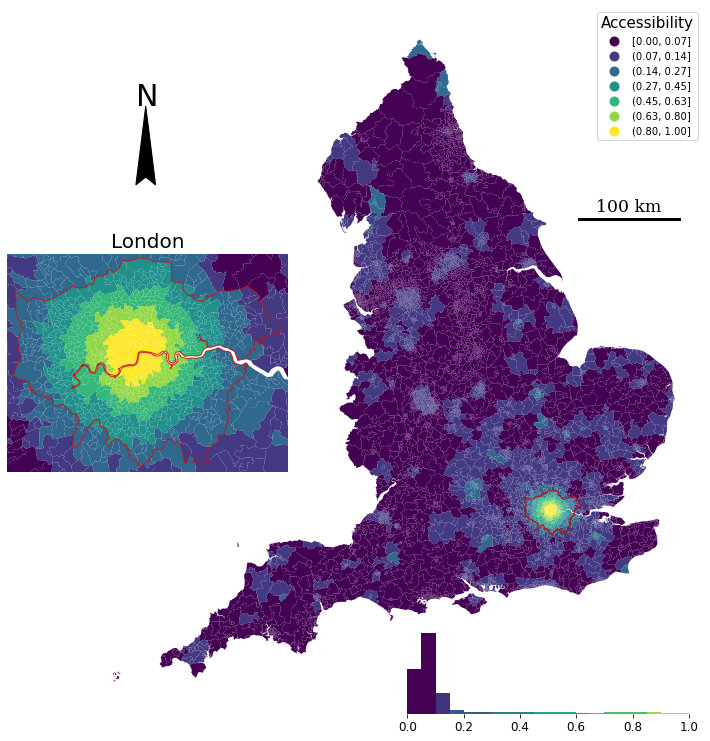

In [156]:
# 20 miles
access_break_1('E2sfca_20_normalized')
plt.savefig('figure/E2sfca_29_include', dpi=600)

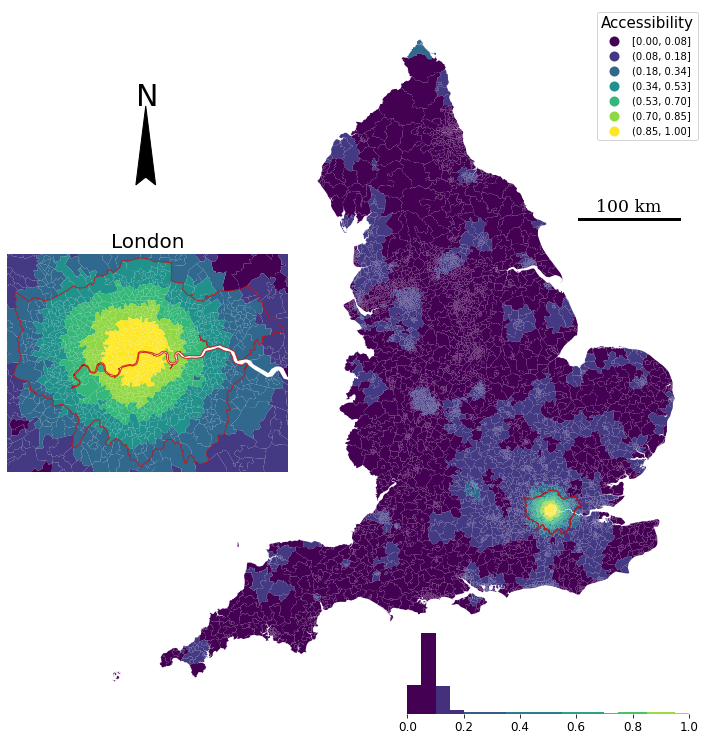

In [157]:
# 25 miles
access_break_1('E2sfca_25_normalized')
plt.savefig('figure/E2sfca_25_include', dpi=600)

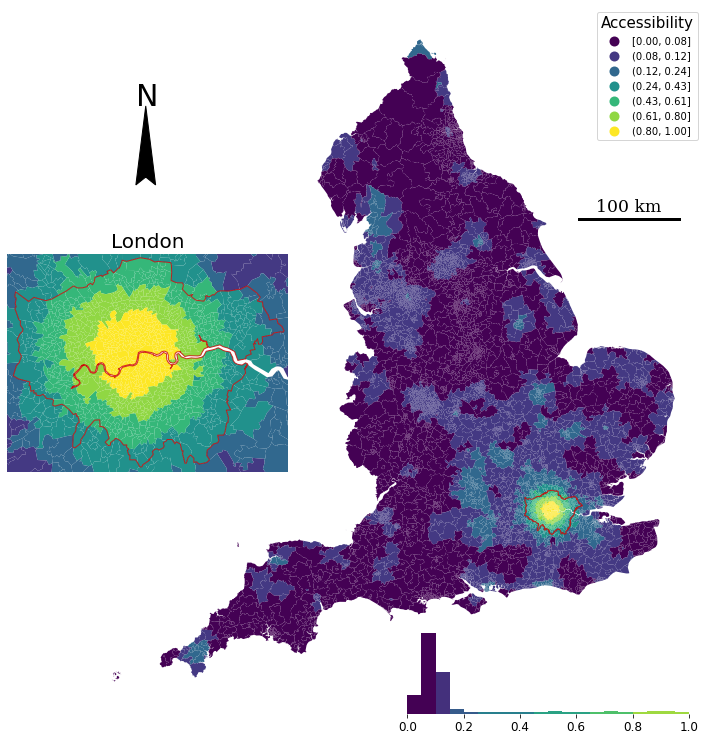

In [158]:
# 30 miles
access_break_1('E2sfca_30_normalized')
plt.savefig('figure/E2sfca_30_include', dpi=600)

### 3SFCA

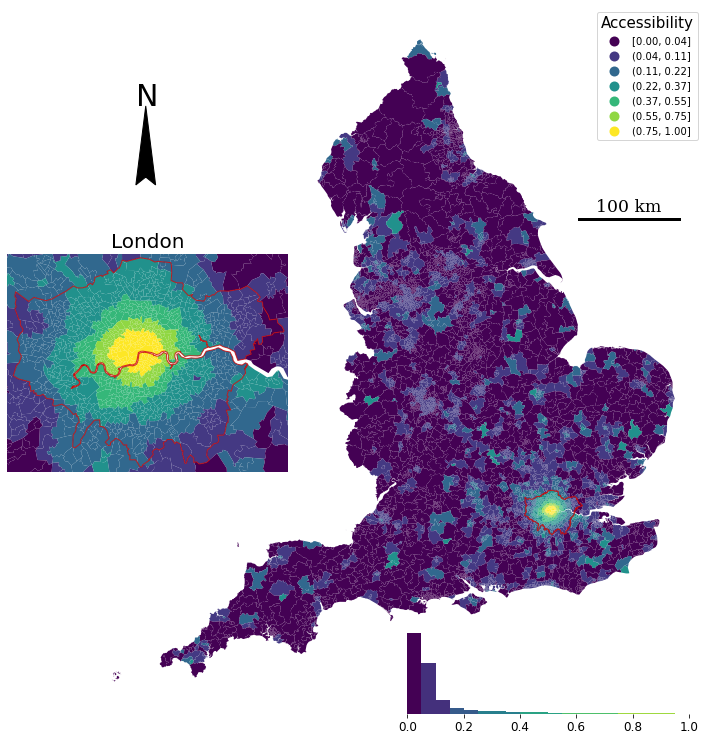

In [159]:
#10 miles
access_break_1('3sfca_10_normalized')
plt.savefig('figure/3sfca_10_include', dpi=600)

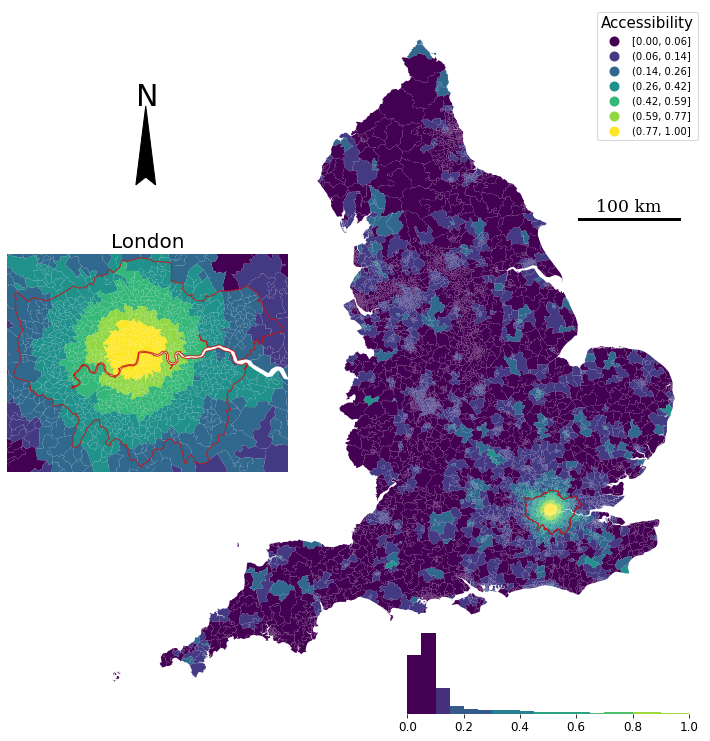

In [160]:
# 15 miles
access_break_1('3sfca_15_normalized')
plt.savefig('figure/3sfca_15_include', dpi=600)

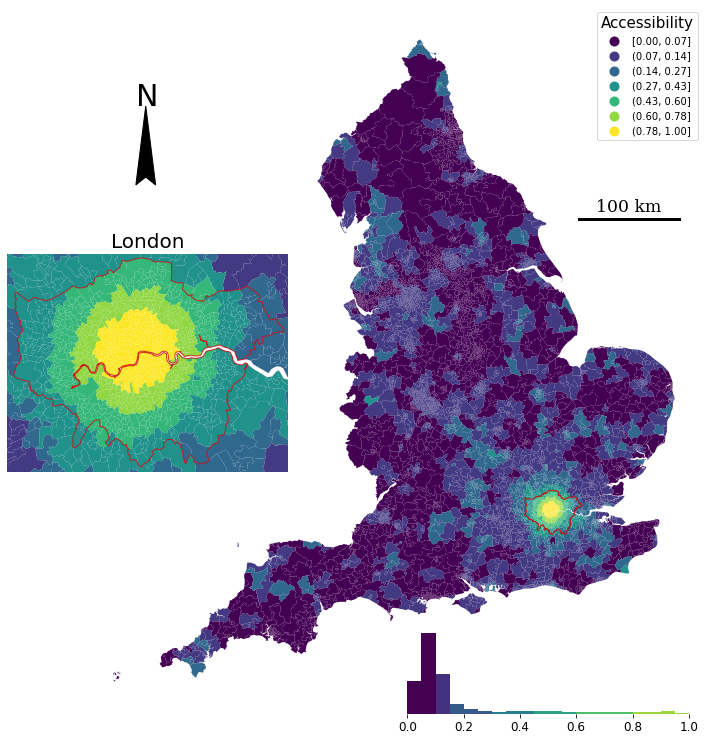

In [161]:
# 20 mimles
access_break_1('3sfca_20_normalized')
plt.savefig('figure/3sfca_20_include', dpi=600)

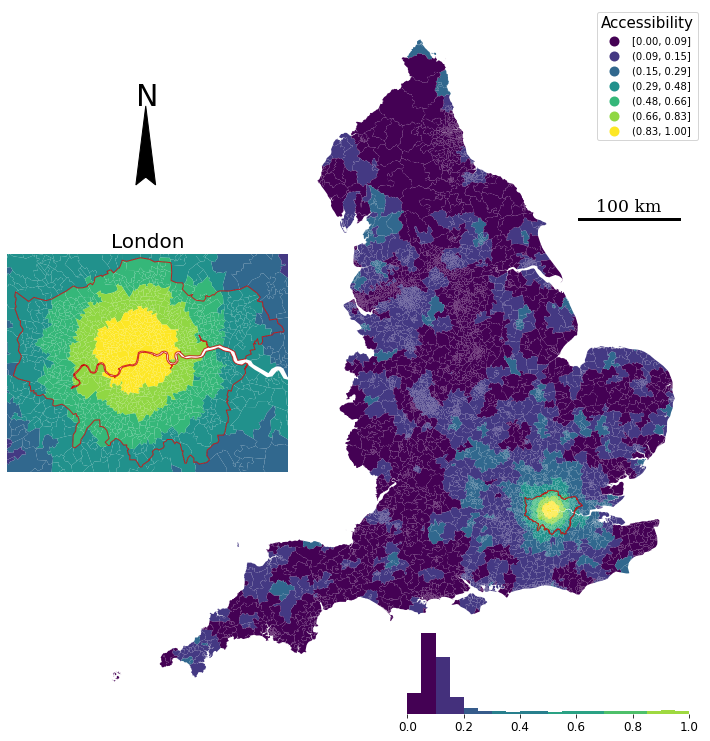

In [162]:
# 25 miles
access_break_1('3sfca_25_normalized')
plt.savefig('figure/3sfca_25_include', dpi=600)

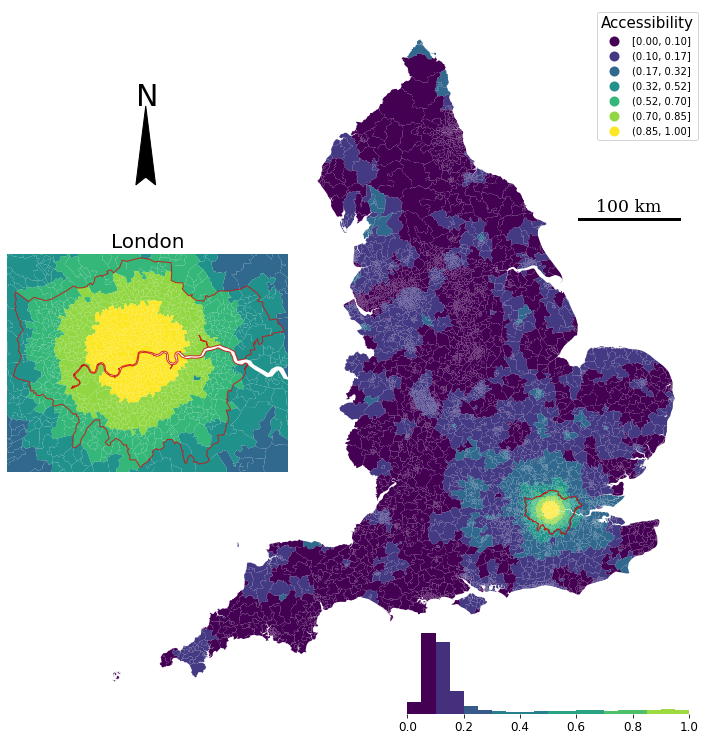

In [163]:
# 30 miles
access_break_1('3sfca_30_normalized')
plt.savefig('figure/3sfca_30_include', dpi=600)

## Vaccination Rate

In [144]:
# for Vaccination Rate (break) with London zooming in
def pop_rate_break_1(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    #ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Vaccination Rate")
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=110000, y=590000, s='N', fontsize=30)
    ax.arrow(120000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)
    
    ax2 = fig.add_axes([0.1, 0.35, 0.3, 0.3])
    MSOA_fca.plot(column=column,edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([502300,562800])
    ax2.set_ylim([154800,201800])
    ax2.set_title('London', fontdict={'fontsize':'20', 'fontweight':'3'})
    London_boundary.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(fig, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

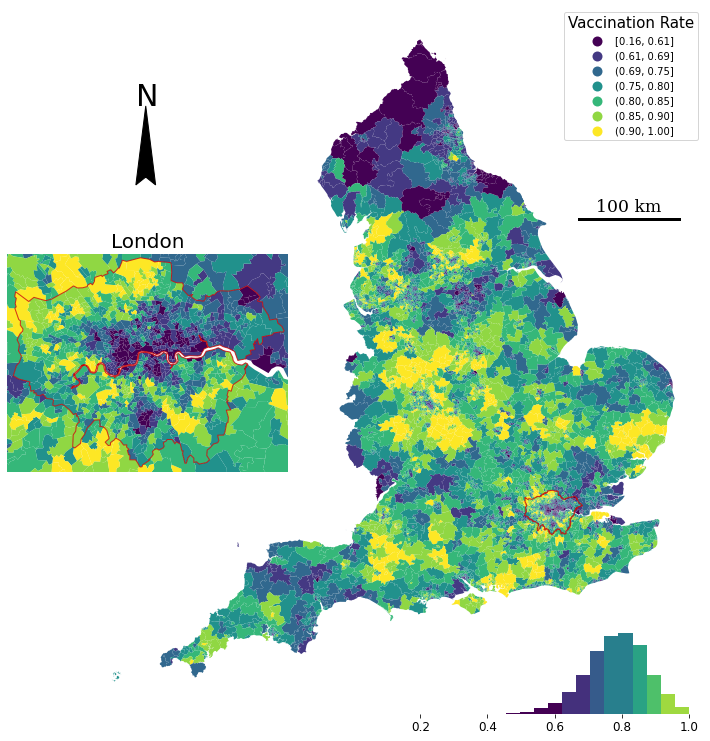

In [145]:
pop_rate_break_1('vaccination_rate_60+69')
plt.savefig('figure/vaccination_rate', dpi=600)

In [11]:
# for London Vaccination Rate map only
def pop_rate_break_London(column):
    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('London Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    #north arrow
    ax.text(x=505000, y=169000, s='N', fontsize=30)
    ax.arrow(506400, 168000, 0, 600, length_includes_head=True,
          head_width=2000, head_length=8000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.1, 0.05), 10,text_kwargs = text_kwargs)

    ax.get_legend().set_title("Accessibility")
    ax.get_legend().get_title().set_fontsize('15')

    q = mc.NaturalBreaks(London[column], k=7)
    legendgram(fig, ax, 
                London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

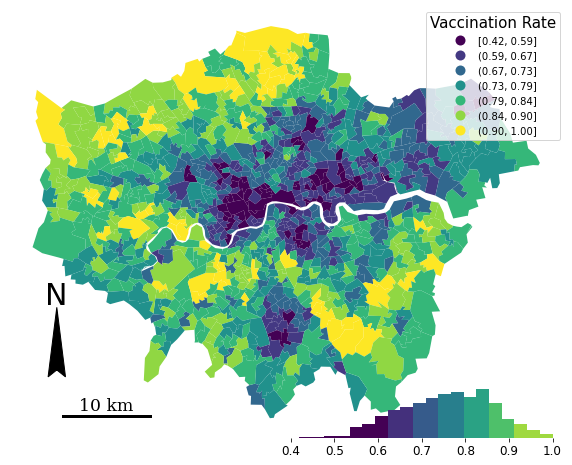

In [147]:
pop_rate_break_London('vaccination_rate_60+69')
#plt.savefig('figure/London_vaccination_rate', dpi=600)

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

### 2SFCA
#### 10mile

In [120]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.2056645924657765
p-value: 9.080615750385992e-66
Spearman correlation coefficient: -0.030699198738981946
p-value: 0.011407048730260912


#### 15 mile

In [121]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.16128160491642302
p-value: 8.349476908159204e-41
Spearman correlation coefficient: -0.01561154822595188
p-value: 0.19832073272177964


#### 20 mile

In [122]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.127665081494815
p-value: 4.476593467601255e-26
Spearman correlation coefficient: -0.018218655473778232
p-value: 0.133303194418481


#### 25 mile

In [123]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.11496600863019801
p-value: 2.0227842346256205e-21
Spearman correlation coefficient: -0.010651002198427956
p-value: 0.38016841040879357


#### 30 mile

In [124]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.10753864974764825
p-value: 6.326799547703783e-19
Spearman correlation coefficient: -0.008470285820881295
p-value: 0.48524016773173007


### E2SFCA

#### 10 mile

In [125]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.23448437804187316
p-value: 1.756823752071746e-85
Spearman correlation coefficient: -0.07267622834839745
p-value: 2.023675006924011e-09


#### 15 mile

In [126]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.22087349488946145
p-value: 8.081596412326752e-76
Spearman correlation coefficient: -0.05312478267208257
p-value: 1.185873184992651e-05


#### 20 mile

In [127]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.20358524824195187
p-value: 1.8699752567872876e-64
Spearman correlation coefficient: -0.038663525665723945
p-value: 0.0014387094301049463


#### 25 mile

In [128]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.18738884688750146
p-value: 1.033833699140086e-54
Spearman correlation coefficient: -0.02934912725621981
p-value: 0.015577593255113816


#### 30 mile

In [129]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.17378647875929842
p-value: 3.4197103376337914e-47
Spearman correlation coefficient: -0.023744903517954705
p-value: 0.05038576728203233


### 3SFCA

#### 10 mile

In [130]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.21555167863716584
p-value: 3.259955972099287e-72
Spearman correlation coefficient: -0.05471133230118395
p-value: 6.44697112248013e-06


#### 15 mile

In [131]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.19489886171543822
p-value: 4.0226087470312e-59
Spearman correlation coefficient: -0.04383971254896196
p-value: 0.00030174828748077346


#### 20 mile

In [132]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.1787122640545214
p-value: 7.588535484071762e-50
Spearman correlation coefficient: -0.03793838097632875
p-value: 0.0017662504912761472


#### 25 mile

In [133]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.16757641353097744
p-value: 5.869574410418524e-44
Spearman correlation coefficient: -0.035451806799607195
p-value: 0.0034792975797188655


#### 30 mile

In [134]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.1599709569673608
p-value: 3.650217593143203e-40
Spearman correlation coefficient: -0.034658899339629755
p-value: 0.004283582873645781
